In [2]:
from transformer_src.dna_tokenizer import (
    DNATokenizer, 
    PRETRAINED_INIT_CONFIGURATION, 
    PRETRAINED_VOCAB_FILES_MAP, 
    PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES, 
    VOCAB_KMER
)
import numpy as np
import torch
import sklearn
import sklearn.metrics as metrics
from transformer_src import dna_tokenizer, data_dnabert

model = "dna6"

vocab = PRETRAINED_VOCAB_FILES_MAP["vocab_file"][model]
config = PRETRAINED_INIT_CONFIGURATION[model]["do_lower_case"]
max_len = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES[model]
tkr = DNATokenizer(vocab, config, max_len)

In [4]:
# Assert that the Tokenizer Works
tokenized = tkr.tokenize(sample)
IDs = [tkr._convert_token_to_id(token) for token in tokenized]
retokenized = [tkr._convert_id_to_token(iD) for iD in IDs]
assert(tokenized == retokenized)

In [5]:
from transformer_src.data_dnabert import SupervisedDataset
import csv

test_dataset = SupervisedDataset("../data/test.tsv", tkr)
val_dataset = SupervisedDataset("../data/val.tsv", tkr, kmer=6)


Perform single sequence classification...
Tokenizing input with 6-mer as input...
Perform single sequence classification...
Tokenizing input with 6-mer as input...


In [6]:
data_path = "../data/val.tsv"
with open(data_path, 'r', newline='\n') as file:
    reader = csv.reader(file, delimiter='\t')
    first_five = list(reader)[1:5]

for line in first_five:
    print(line)

import numpy as np
first_five = np.array(first_five)
labels = first_five[:, 1]
print(labels)

labels = labels[1:]
print(labels)


output = tkr(
            list(first_five[:,0]),
            return_tensors="pt",
            padding="longest",
            max_length=tkr.model_max_length,
            truncation=True,
)
output_ids = output["input_ids"]
print(output_ids)

['GAAACA AAACAC AACACC ACACCT CACCTT ACCTTC CCTTCT CTTCTA TTCTAC TCTACA CTACAT TACATT ACATTG CATTGC ATTGCC TTGCCT TGCCTG GCCTGC CCTGCC CTGCCT TGCCTA GCCTAA CCTAAA CTAAAT TAAATG AAATGG AATGGT ATGGTT TGGTTT GGTTTG GTTTGT TTTGTC TTGTCT TGTCTC GTCTCT TCTCTG CTCTGC TCTGCA CTGCAA TGCAAT GCAATC CAATCA AATCAA ATCAAT TCAATC CAATCT AATCTC ATCTCT TCTCTC CTCTCT TCTCTA CTCTAT TCTATT CTATTC TATTCT ATTCTT TTCTTT TCTTTA CTTTAA TTTAAA TTAAAA TAAAAC AAAACA AAACAG AACAGA ACAGAA CAGAAT AGAATT GAATTA AATTAG ATTAGG TTAGGA TAGGAT AGGATA GGATAA GATAAT ATAATT TAATTT AATTTG ATTTGC TTTGCA TTGCAT TGCATA GCATAA CATAAT ATAATT TAATTG AATTGT ATTGTT TTGTTT TGTTTC GTTTCT TTTCTT TTCTTG TCTTGT CTTGTC TTGTCT TGTCTC GTCTCA TCTCAG CTCAGA TCAGAG CAGAGA AGAGAA GAGAAA AGAAAT GAAATC AAATCT AATCTT ATCTTA TCTTAC CTTACA TTACAG TACAGG ACAGGG CAGGGA AGGGAG GGGAGG GGAGGC GAGGCT AGGCTG GGCTGT GCTGTC CTGTCT TGTCTC GTCTCC TCTCCA CTCCAG TCCAGA CCAGAT CAGATA AGATAA GATAAC ATAACC TAACCA AACCAG ACCAGC CCAGCA CAGCAG AGCAGC GCAGCC CAGCCT AGCC

In [7]:
print(type(val_dataset.labels))
val_dataset.labels = (val_dataset.labels).astype(np.int8)
if -1 in val_dataset.labels:
    print("add")
    val_dataset.labels += 1
print(val_dataset.labels)
np.count_nonzero(val_dataset.labels == 1)

<class 'numpy.ndarray'>
[0 0 0 ... 1 1 1]


19578

In [8]:
# Test out Tokenizer
to_id = tkr.vocab
to_tk = tkr.ids_to_tokens

KMER="TAGATA"
print(to_id[KMER])
assert to_tk[to_id[KMER]] == KMER

KMER="[UNK]"
print(to_id[KMER])
assert to_tk[to_id[KMER]] == KMER

1225
1


In [9]:
DATA_PATH="../data/"
MODEL_PATH="pretrained_6mer/pytorch_model.bin"
CONFIG_FILE="pretrained_6mer/"

import transformers
import json

with open("labels.json", "r") as jfile:
        data = json.load(jfile)

label2id = data.get("label2id", {})
id2label = {v: k for k, v in label2id.items()}

# load model
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    CONFIG_FILE,
    cache_dir=None,
    num_labels=3,
    trust_remote_code=True,
    id2label=id2label,
    label2id=label2id,
    output_attentions=True
)

Some weights of the model checkpoint at pretrained_6mer/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pretrained_6mer/ and are new

In [10]:
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    PeftConfig,
    PeftModel
)

PEFT_CONFIG = "../output/best_berten_718"
config = PeftConfig.from_pretrained(PEFT_CONFIG)
inference_model = PeftModel.from_pretrained(model, PEFT_CONFIG)

In [11]:
from torch.utils.data import DataLoader
torch.cuda.empty_cache()
print(test_dataset.input_ids)
test_labels = np.asarray(test_dataset.labels)
pos_test_ind = np.where(test_labels != 1)
pos_labels = test_labels[pos_test_ind]

pos_test_inputs = test_dataset.input_ids[pos_test_ind]
# with torch.no_grad():
#     pos_test_outputs = inference_model(pos_test_inputs)

outputs = inference_model(pos_test_inputs[0:32])

tensor([[   2, 3394, 1276,  ..., 2783, 2927,    3],
        [   2, 3149,  295,  ..., 1305, 1109,    3],
        [   2, 1540, 2050,  ...,  349, 1383,    3],
        ...,
        [   2, 1634, 2427,  ..., 2110,  236,    3],
        [   2, 2315, 1055,  ..., 1640, 2449,    3],
        [   2,   56,  210,  ..., 1060,  129,    3]])


In [12]:
# logits = [o.logits for o in all_outputs]
# auc_poised = metrics.roc_auc_score((labels == 0), logits[:,0])
# auc_active = metrics.roc_auc_score((labels == 2), logits[:,2])

out_logits = outputs.logits.detach().numpy()
out_attens = outputs.attentions

out_preds = np.argmax(out_logits, 1)
print(out_preds)
print(pos_labels[0:32])
print(out_logits)

[2 1 1 0 0 2 0 0 2 1 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 2 0 1]
[0 0 2 2 2 0 0 0 0 0 2 2 0 0 0 2 0 0 0 0 0 0 2 0 0 0 2 2 2 0 0 0]
[[ 1.4694904  -3.715859    1.6319729 ]
 [ 0.22450462  1.1266026  -1.344702  ]
 [-0.6582938   1.5553082  -0.9183842 ]
 [ 0.27008897 -0.4446012  -0.2815431 ]
 [ 1.1717923  -1.3785945   0.06456447]
 [ 0.6867998  -2.008314    0.6939264 ]
 [ 0.6102344  -0.85901725 -0.38486955]
 [ 0.6075369   0.08034042 -1.0003251 ]
 [-0.5651592  -0.05489397  0.43435127]
 [ 0.07853912  0.08618436 -0.51036143]
 [-0.16174465 -0.03168217 -0.22989938]
 [-1.4850552   0.87799644  0.45472038]
 [ 1.4103605  -2.1115088   0.0572914 ]
 [ 1.2462633  -2.7270896   0.8862874 ]
 [ 0.21150273  0.13649042 -0.72857875]
 [ 0.16674441 -0.4823397  -0.12227949]
 [ 0.35433474  0.8688714  -1.1121366 ]
 [ 1.9824594  -2.26495    -0.19846585]
 [ 0.150716    0.39757645 -0.73402613]
 [ 0.7297761  -0.6467593  -0.6782571 ]
 [ 0.8585761  -1.0916729  -0.11340973]
 [-0.69404995  1.1850083  -0.6181369 ]
 [-0.74174

In [13]:
print(out_attens[0].size())

torch.Size([32, 12, 496, 496])


In [14]:


def process_scores(attention_scores, kmer):
    scores = np.zeros([attention_scores.shape[0], attention_scores.shape[-1]])

    # attention_scores: (batch_size, num_heads, seq_len, seq_len)
    for index, attention_score in enumerate(attention_scores):
        attn_score = []
        # print(attention_score.shape)
        for i in range(1, attention_score.shape[-1] - kmer + 2):
            attn_score.append(float(attention_score[:, 0, i].sum()))

        for i in range(len(attn_score) - 1):
            if attn_score[i + 1] == 0:
                attn_score[i] = 0
                break
        
        # print(len(attn_score))

        # attn_score[0] = 0
        counts = np.zeros([len(attn_score) + kmer - 1])
        real_scores = np.zeros([len(attn_score) + kmer - 1])
        for i, score in enumerate(attn_score):
            for j in range(kmer):
                counts[i + j] += 1.0
                real_scores[i + j] += score
        real_scores = real_scores / counts
        real_scores = real_scores / np.linalg.norm(real_scores)

        scores[index] = real_scores
    return scores

def process_multi_score(attention_scores, kmer):
    scores = np.zeros([attention_scores.shape[0], attention_scores.shape[1], attention_scores.shape[-1]])

    # attention_scores: (batch_size, num_heads, seq_len, seq_len)
    for index, attention_score in enumerate(attention_scores):

        head_scores = np.zeros([attention_scores.shape[1], attention_scores.shape[-1]])
        for head in range(0, len(attention_score)):
            attn_score = []
            
            for i in range(1, attention_score.shape[-1] - kmer + 2):
                attn_score.append(float(attention_score[head, 0, i]))

            for i in range(len(attn_score) - 1):
                if attn_score[i + 1] == 0:
                    attn_score[i] = 0
                    break
    
            counts = np.zeros([len(attn_score) + kmer - 1])
            real_scores = np.zeros([len(attn_score) + kmer - 1])

            for i, score in enumerate(attn_score):
                for j in range(kmer):
                    counts[i + j] += 1.0
                    real_scores[i + j] += score
            real_scores = real_scores / counts
            real_scores = real_scores / np.linalg.norm(real_scores)

            head_scores[head] = real_scores

        scores[index] = head_scores
    return scores


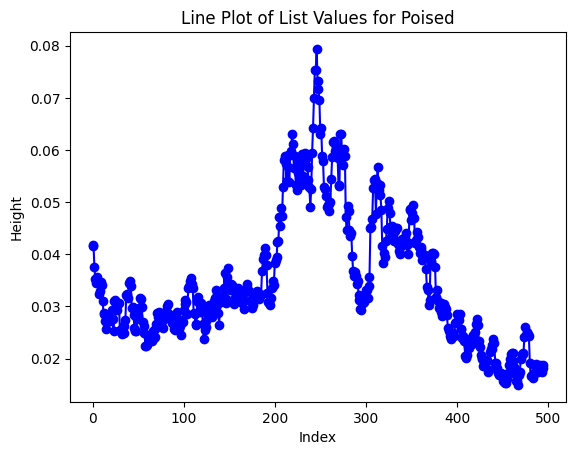

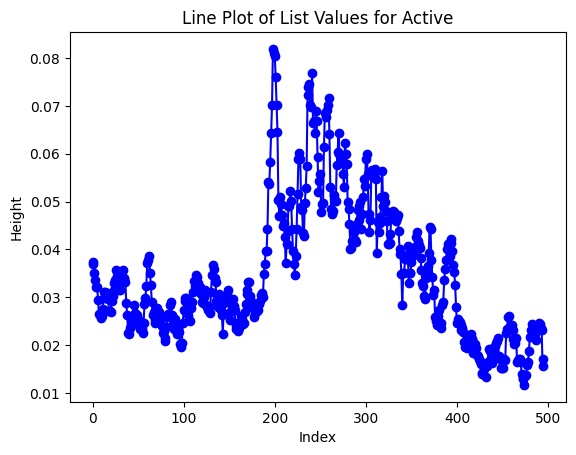

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [56]:
import matplotlib.pyplot as plt

colors = [
    'blue',        # Blue
    'green',       # Green
    'red',         # Red
    'purple',      # Purple
    'orange',      # Orange
    'brown',       # Brown
    'pink',        # Pink
    'gray',        # Gray
    'olive',       # Olive
    'cyan',        # Cyan
    'magenta',     # Magenta
    'teal'         # Teal
]

def plot_line(values, name):
    x_values = list(range(len(values)))

    # Create the plot
    plt.plot(x_values, values, marker='o', linestyle='-', color='b')

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Height')
    plt.title(f'Line Plot of List Values for {name}')

    # Show the plot
    plt.show()

def plot_multi_line(list_values):
    x_values = list(range(len(list_values[0])))
    fig, axs = plt.subplots(3, 4, figsize=(12,9))

    axs = axs.flatten()

    for i, ax in enumerate(axs):
        ax.plot(x_values, list_values[i], linestyle='-', color=colors[i])
        ax.set_title(f'Plot for Head {i+1}')
        ax.set_xlabel('Base Pair')
        ax.set_ylabel('Average Attention for Head')

    plt.tight_layout()

    # Show the plot
    plt.show()

import random
def plot_random(attentions):
    random_indices = np.random.choice(len(attentions), 12, replace=False)
    sample = attentions[random_indices]

    x_values = list(range(len(attentions[0])))
    fig, axs = plt.subplots(3, 4, figsize=(12,9))

    axs = axs.flatten()

    for i, ax in enumerate(axs):
        ax.plot(x_values, sample[i], linestyle='-', color=colors[i])
        ax.set_title(f'Plot for Sample {i+1}')
        ax.set_xlabel('Base Pair')
        ax.set_ylabel('Attention Score')

    plt.tight_layout()

    # Show the plot
    plt.show()



# from transformer_src.evaluate_model import process_scores, process_multi_score

atten_scores = (out_attens[-1]).numpy()
procs_scores = process_scores(atten_scores, 6)
# procs_scores = process_scores(atten_scores, 6)
values = procs_scores[31]
poised_indices = np.where(test_labels[0:32] == 0)
active_indices = np.where(test_labels[0:32] == 2)
val_poised = np.average(procs_scores[poised_indices], 0)
val_active = np.average(procs_scores[active_indices], 0)

plot_line(val_poised, "Poised")
plot_line(val_active, "Active")

plot_random(procs_scores)



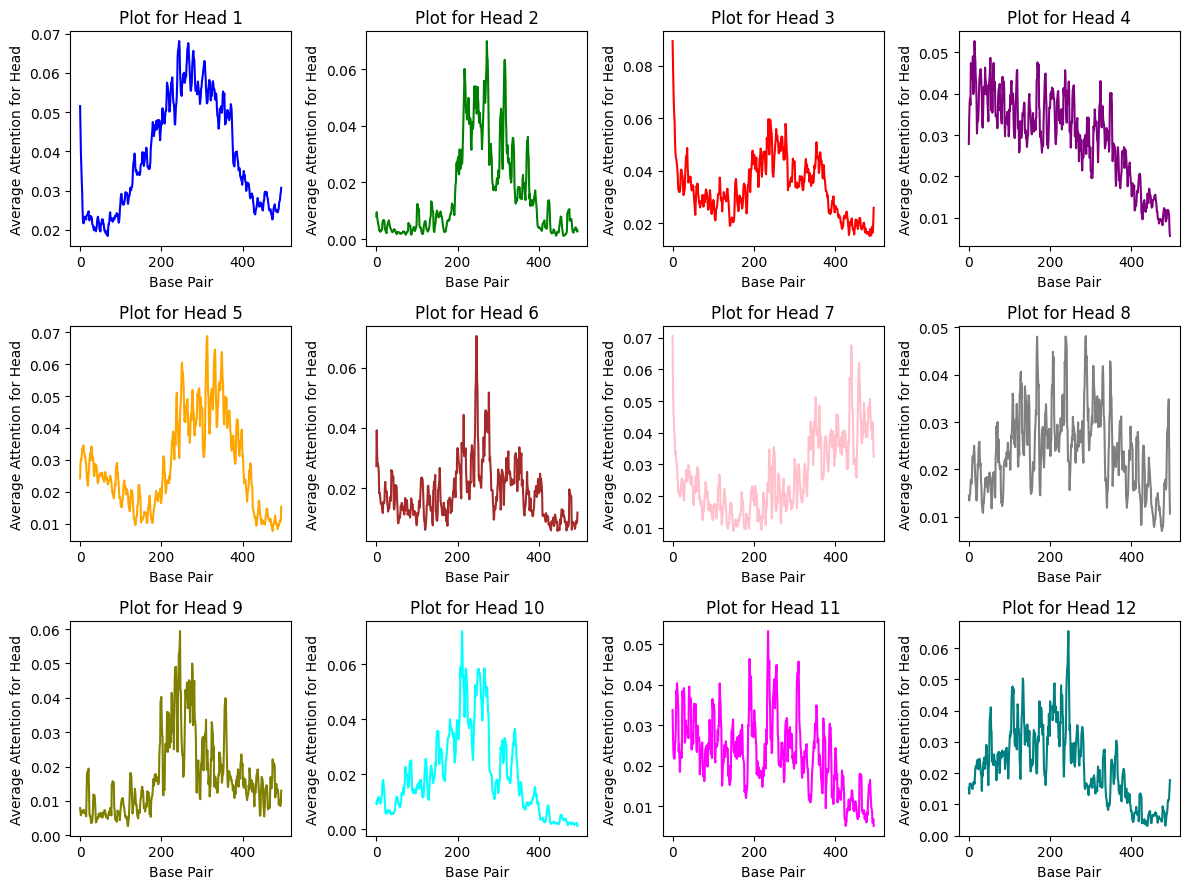

In [54]:
multi_attn_result = process_multi_score((out_attens[-1]).numpy(), kmer=6)
multi_average = np.average(multi_attn_result, 0)
plot_multi_line(multi_average)



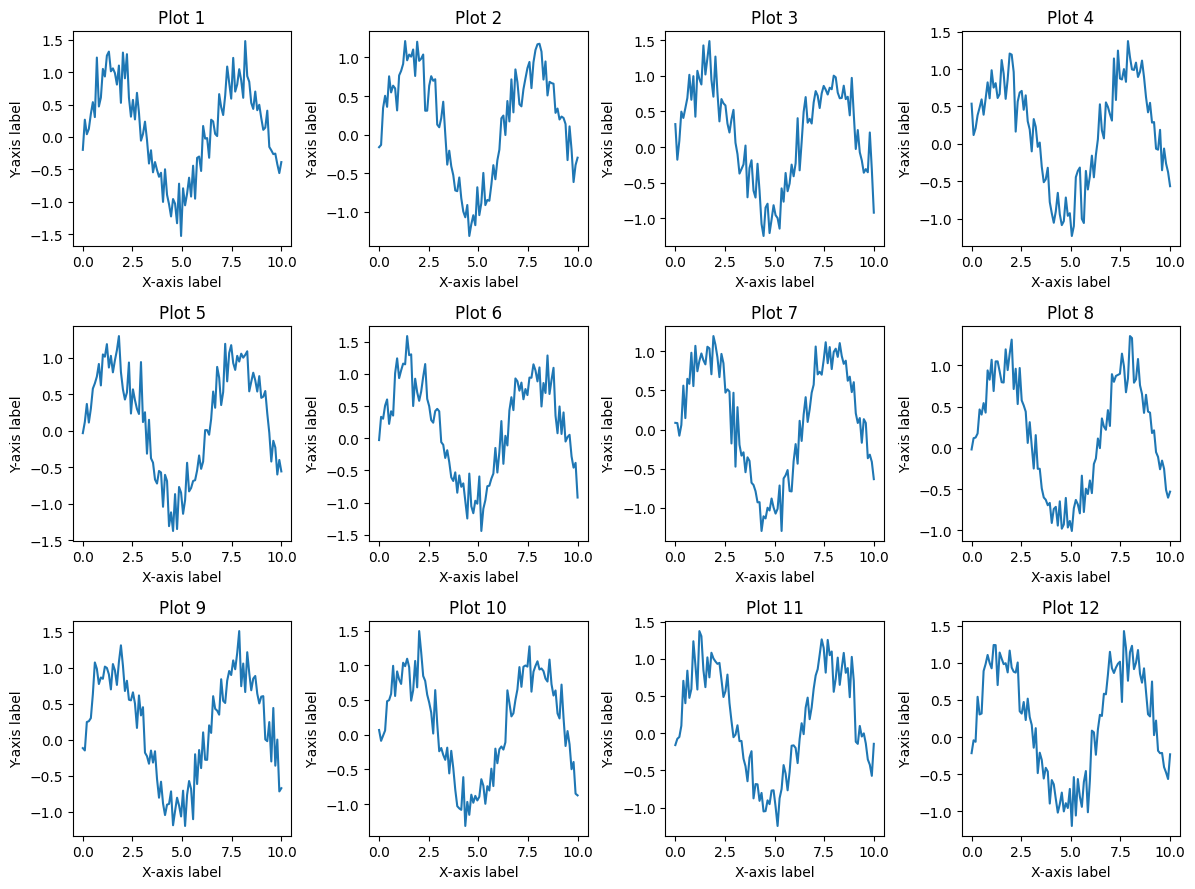

In [48]:
# Sample data (replace these with your actual data)
x = np.linspace(0, 10, 100)
data = [np.sin(x) + np.random.normal(0, 0.2, len(x)) for _ in range(12)]

# Create a 3x4 grid for the subplots
fig, axs = plt.subplots(3, 4, figsize=(12, 9))

# Flatten the axs array to access each subplot one by one
axs = axs.flatten()

# Plot each line on its corresponding subplot
for i, ax in enumerate(axs):
    ax.plot(x, data[i])
    ax.set_title(f'Plot {i+1}')
    ax.set_xlabel('X-axis label')
    ax.set_ylabel('Y-axis label')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()